In [43]:
import torch
import pandas as pd

torch.__version__

'2.8.0+cu126'

In [44]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [45]:
from sklearn.model_selection import train_test_split

In [46]:
device = 'cpu'

In [47]:
data = pd.read_csv('data/processed_smoke_detector.csv')
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],NC2.5,Fire Alarm,IsItDay?,Weekday_0,Weekday_1,Weekday_2
0,27.041,49.80,19.0,400.0,13059.0,19951,939.777,0.011,0,0,0,0,1
1,26.987,54.26,1.0,400.0,13078.0,19975,939.765,0.011,0,0,0,0,1
2,26.985,53.66,10.0,400.0,13068.0,19955,939.768,0.011,0,0,0,0,1
3,26.983,53.07,10.0,400.0,13069.0,19963,939.775,0.013,0,0,0,0,1
4,26.982,52.57,13.0,400.0,13072.0,19958,939.770,0.013,0,0,0,0,1


In [48]:
y, X = data['Fire Alarm'].values, data.drop(columns=['Fire Alarm']).values
#y = y.reshape(-1, 1)
X.shape, y.shape

((41247, 12), (41247,))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32997, 12), (8250, 12), (32997,), (8250,))

In [50]:
from torch.utils.data import TensorDataset, DataLoader

In [51]:
train_ds = TensorDataset(torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.long))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

# Creating FCNN Classification model

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 2)
        # softmax is not used as CrossEntropyLoss combines CrossEntropyLossnn.LogSoftmax() and nn.NLLLoss() in one class

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
model = ClassificationNet().to(device)
class_weights = torch.tensor([1.2, 1.0]).to(device) # weights for classes for FN -> min
loss_function = nn.CrossEntropyLoss(weight=class_weights).to(device)
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_dl:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    epoch_loss.append(loss.item())

In [56]:
import matplotlib.pyplot as plt

In [57]:
epoch_loss

[47.77039337158203,
 8.363259315490723,
 5.029675006866455,
 2.142673969268799,
 0.7776015996932983,
 0.4023357927799225,
 0.2248159945011139,
 0.31961384415626526,
 0.16958923637866974,
 0.08603451400995255,
 0.03261671960353851,
 0.03867446631193161,
 0.07077895849943161,
 0.08796343952417374,
 0.028563151136040688,
 0.19600854814052582,
 0.05352063104510307,
 0.17677411437034607,
 0.16503150761127472,
 0.15130089223384857]

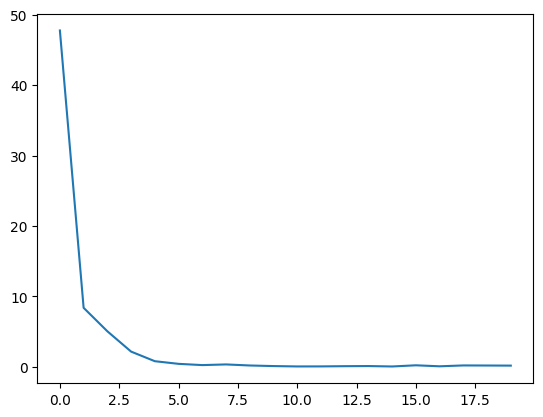

In [59]:
plt.plot(epoch_loss)

In [61]:
model.eval()
with torch.no_grad():
    outputs = model(torch.from_numpy(X_test).float())
    _, predicted_classes = torch.max(outputs, 1)

predicted_classes_np = predicted_classes.numpy()

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:\n")
report = classification_report(y_test, predicted_classes_np, target_names=['Class 0', 'Class 1'])
print(report)

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, predicted_classes_np)
print(cm)

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.92      0.88      0.90      1819
     Class 1       0.97      0.98      0.97      6431

    accuracy                           0.96      8250
   macro avg       0.94      0.93      0.93      8250
weighted avg       0.95      0.96      0.96      8250


Confusion Matrix:

[[1597  222]
 [ 146 6285]]
